In [2]:
!pip install pycaret


KNN Cross-Validation Accuracy: 0.7249720821813845 ± 0.019952718083979814
Logistic Regression Cross-Validation Accuracy: 0.838017021737952 ± 0.05212746897176803
Random Forest Cross-Validation Accuracy: 0.9301404022334255 ± 0.06426205709841978


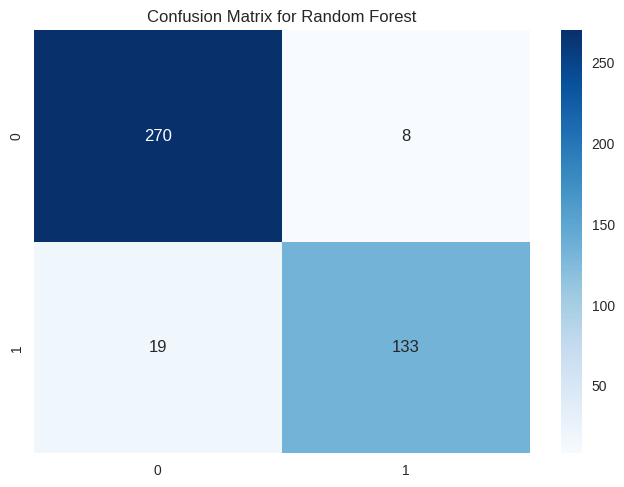

Random Forest Accuracy: 0.9372093023255814
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       278
         1.0       0.94      0.88      0.91       152

    accuracy                           0.94       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430



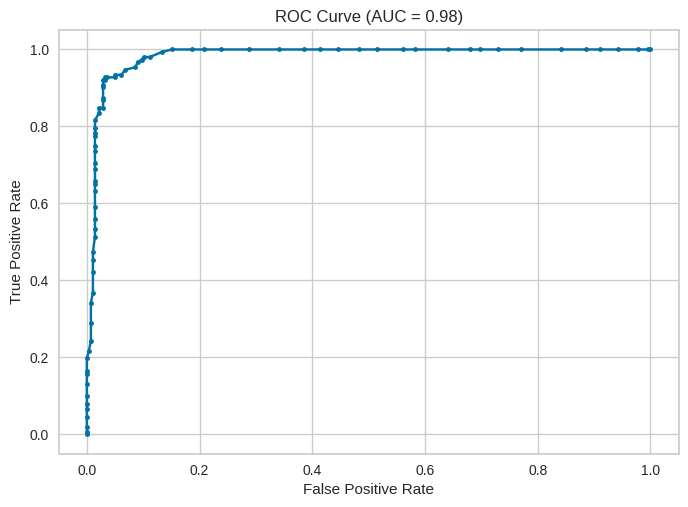

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9546,0.9897,0.9425,0.9315,0.9365,0.9012,0.9018,0.6880
xgboost,Extreme Gradient Boosting,0.9540,0.9895,0.9407,0.9309,0.9355,0.8998,0.9002,0.2090
gbc,Gradient Boosting Classifier,0.9476,0.9800,0.9227,0.9303,0.9258,0.8854,0.8861,0.9040
dt,Decision Tree Classifier,0.9360,0.9285,0.9029,0.9160,0.9091,0.8597,0.8602,0.0550
rf,Random Forest Classifier,0.9319,0.9805,0.8568,0.9463,0.8990,0.8478,0.8506,0.5390
ada,Ada Boost Classifier,0.9151,0.9484,0.8685,0.8922,0.8787,0.8134,0.8152,0.4850
et,Extra Trees Classifier,0.8517,0.9345,0.6924,0.8637,0.7664,0.6600,0.6702,0.5480
ridge,Ridge Classifier,0.8319,0.8984,0.7204,0.7892,0.7509,0.6247,0.6281,0.0420
lda,Linear Discriminant Analysis,0.8313,0.8985,0.7286,0.7829,0.7526,0.6251,0.6279,0.0410
lr,Logistic Regression,0.8255,0.8841,0.7087,0.7771,0.7398,0.6093,0.6119,0.5100


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
The best model selected by PyCaret is: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Results Summary:
KNN Cross-Validation Accuracy: 0.7249720821813845 ± 0.

In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/content/alzheimers_disease_data.csv")  # Update with your file path

# Replace any known invalid entries with NaN
data.replace('XXXConfid', np.nan, inplace=True)

# Drop columns with all missing values (if any)
data.dropna(axis=1, how='all', inplace=True)

# Impute missing values with the mean (or another strategy)
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(data)

# Create a new DataFrame with the imputed data
data = pd.DataFrame(imputed_data, columns=data.columns)

# Ensure that categorical variables are encoded
le = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

# Splitting the dataset into features and target
X = data.drop(['Diagnosis'], axis=1)
y = data['Diagnosis']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the models
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)

# Cross-validation for KNN
skf = StratifiedKFold(n_splits=5)
cv_scores_knn = cross_val_score(knn, X, y, cv=skf, scoring='accuracy')
print(f"KNN Cross-Validation Accuracy: {cv_scores_knn.mean()} ± {cv_scores_knn.std()}")

# Cross-validation for Logistic Regression
cv_scores_log_reg = cross_val_score(log_reg, X, y, cv=skf, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy: {cv_scores_log_reg.mean()} ± {cv_scores_log_reg.std()}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf, X, y, cv=skf, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {cv_scores_rf.mean()} ± {cv_scores_rf.std()}")

# Train and predict with Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation with Confusion Matrix and ROC Curve for Random Forest
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

# ROC Curve and AUC Score
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_rf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# PyCaret for Automated Model Comparison
from pycaret.classification import *

# Setup PyCaret with the dataset
clf_setup = setup(data=data, target='Diagnosis',  # Replace with the actual target column name
                  train_size=0.8, session_id=123,
                  verbose=False, use_gpu=False)

# Compare models
best_model = compare_models()
print(best_model)

# Finalize the best model
final_model = finalize_model(best_model)

# Conclusion and Known Issues
# Summary of the best model selected
print(f"The best model selected by PyCaret is: {best_model}")

# Discuss the results
print("Results Summary:")
print(f"KNN Cross-Validation Accuracy: {cv_scores_knn.mean()} ± {cv_scores_knn.std()}")
print(f"Logistic Regression Cross-Validation Accuracy: {cv_scores_log_reg.mean()} ± {cv_scores_log_reg.std()}")
print(f"Random Forest Cross-Validation Accuracy: {cv_scores_rf.mean()} ± {cv_scores_rf.std()}")
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Known Issues
known_issues = """
1. Potential Bias: The dataset may have class imbalance, leading to biased model performance.
2. Missing Data: Imputation with mean might not be the best strategy for all features.
3. Encoding: Label encoding may not preserve ordinal relationships if they exist.
4. Model Overfitting: Random Forest model might be overfitting if not properly tuned.
"""

print("Known Issues:")
print(known_issues)
